In [1]:
from models import Discriminator, UNet, Generator
from datasets import ImageDataset,tophat
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch
import torchvision
from skimage import io, morphology
import matplotlib.pyplot as plt
import numpy as np
from models import UNet,Generator
from PIL import Image,ImageOps
from tqdm import tqdm
import random
import cv2
from utils import fusion_predict, make_mask, merge_ckpts, denorm
%load_ext autoreload
%autoreload 2

### 评估

In [3]:
def gen_simple(ds,ids,th = 0.03, contrast=1, gamma=1.5, size=256, autocontrast=True, cutoff=0):
    grids = []
    for idx in ids:
        A = ds[idx]["A"]
        B = ds[idx]["B"]
        B_dnorm = torchvision.utils.make_grid(B, normalize=True, padding=0)
        B_dnorm = T.CenterCrop(size)(B_dnorm)
        
        fakeA = netG_B2A.model(B.unsqueeze(0))
        out = (fakeA[0] > th).float()
        out = torchvision.utils.make_grid(out, normalize=True, padding=0)
        out = T.CenterCrop(size)(out)
        # denoise
#         out = (out.permute(1,2,0).numpy()*255).astype('uint8')
#         out = cv2.fastNlMeansDenoisingColored(out,None,50,50,7,21)
#         out = T.ToPILImage()(out)
#         out = T.ToTensor()(out)


        SA = T.CenterCrop(size)(fakeA)
        SA = torchvision.utils.make_grid(SA, normalize=True, padding=0)
        if autocontrast:
            SA = T.ToPILImage()(SA)
            SA = ImageOps.autocontrast(SA,cutoff=cutoff)
            SA = T.ToTensor()(SA)

#         SA = T.functional.adjust_contrast(SA, contrast)
        SA = T.functional.adjust_gamma(SA, gamma)
    
#         SA = (SA.permute(1,2,0).numpy()*255).astype('uint8')
#         SA = cv2.fastNlMeansDenoisingColored(SA,None,10,10,7,21)
#         SA = T.ToPILImage()(SA)
#         SA = T.ToTensor()(SA)
        
        grid = torchvision.utils.make_grid([B_dnorm, SA, out], nrow=1, padding=1,pad_value=1)
        grids.append(grid)
        
    
    grids = torchvision.utils.make_grid(grids, nrow=len(ids))
    return T.ToPILImage()(grids)

In [3]:
tfmc = T.Compose([
#     T.Lambda(lambda x:ImageOps.autocontrast(x,cutoff=1)),
    T.Resize(256),
#     T.Pad(50, padding_mode='edge'),
#     T.RandomHorizontalFlip(p=1),
    T.Lambda(lambda x:T.functional.rotate(x,0)),
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

ds = ImageDataset('datasets/cycledsa_v4/', size=256, unaligned=False, mode='test', transform=tfmc)

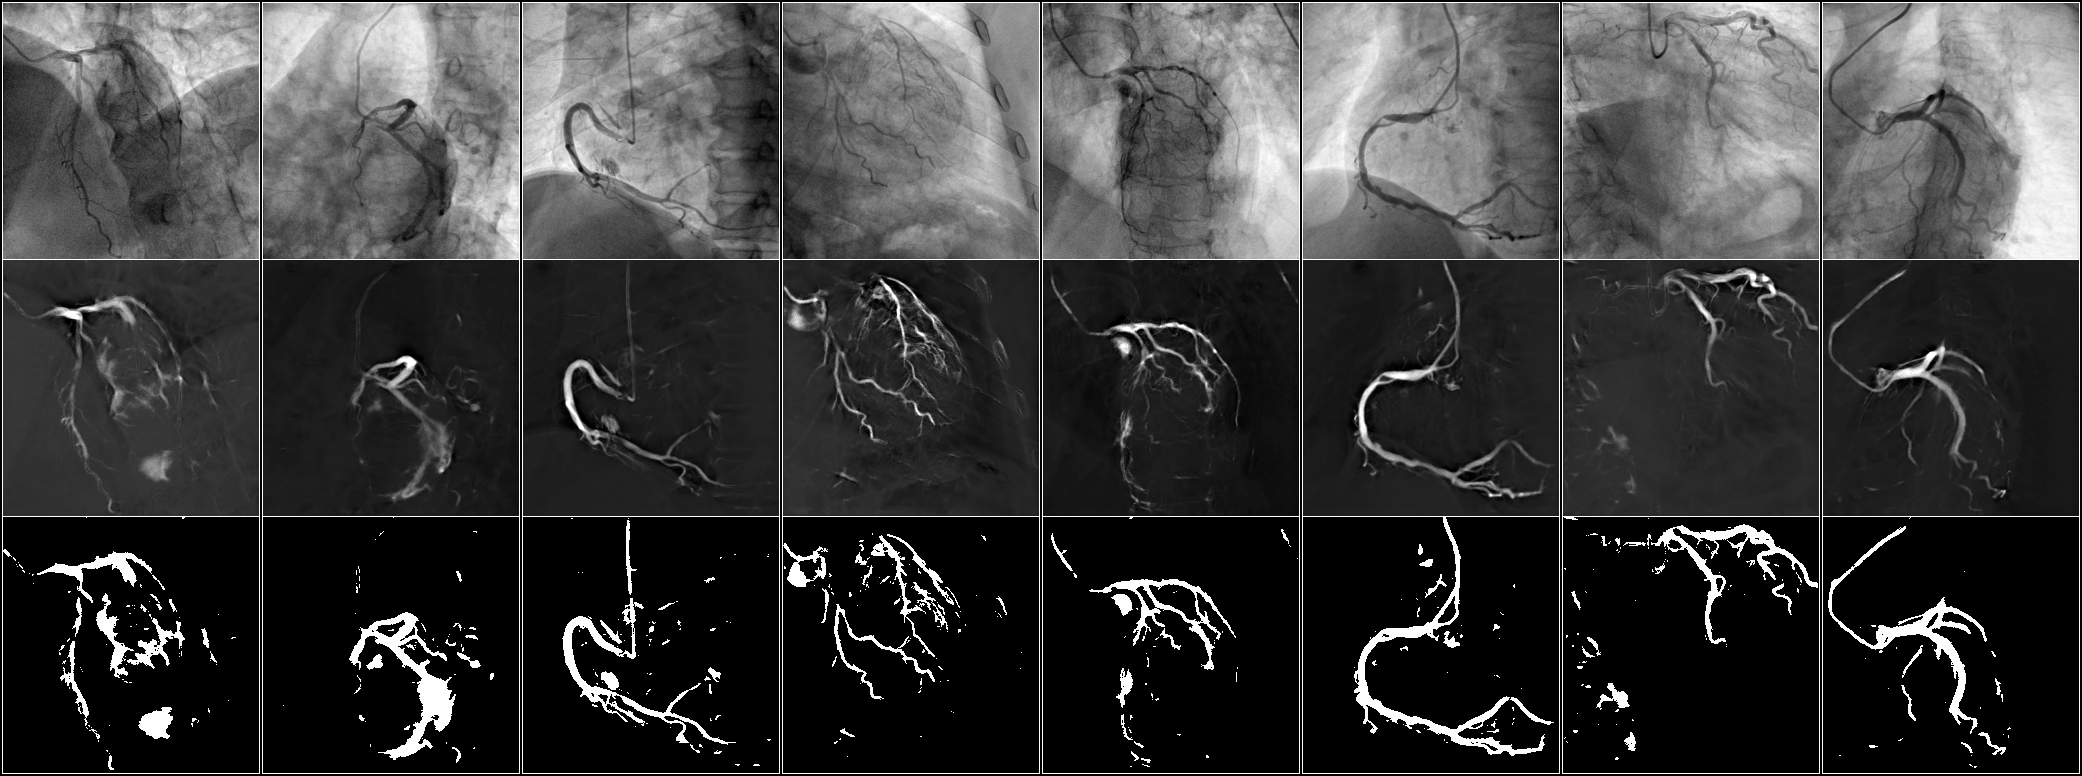

In [12]:
netG_B2A = UNet(1, 1, 32)
# netG_B2A = Generator(1,1)
# checkpoint = torch.load(f'mlruns/0/1e11858775af46a18789fe97d1a789d5/030.ckpt', map_location='cpu')  # unet32_down3

checkpoint = torch.load(f'mlruns/2/0144d53a8ca7439a8857c9ab2fbf96bc/last.ckpt', map_location='cpu') # norp 可以加入



netG_B2A.eval()
netG_B2A.load_state_dict(checkpoint["netG_B2A"])
# netG_B2A.load_state_dict(checkpoint['netE'])

# ids = [9, 10, 11, 12, 99, 100, 101,108]
# ids = [13, 14, 15, 21, 32, 33, 45]
ids =[13,14,33,9,10,99,108,45]

gen_simple(ds,ids,th=0.03, gamma=1.2, autocontrast=True, cutoff=0.1)

In [2]:
netG_B2A = UNet(1, 1, 32)
# checkpoint = torch.load(f'goodckpt/idt20_030.ckpt', map_location='cpu') #
# checkpoint = torch.load(f'mlruns/0/196367abb77a4e13b7fc0b7f04d82762/030.ckpt', map_location='cpu') # idt10
# checkpoint = torch.load(f'mlruns/0/7d922e698c114a74af3c22f2ba4cc131/049.ckpt', map_location='cpu') # 1e4
# checkpoint = torch.load(f'mlruns/0/f97f3358ba5341d5a5eba7a965e8f957/020.ckpt', map_location='cpu') # nocrop
# checkpoint = torch.load(f'mlruns/0/b20b293d35a846abb1359a6dadaa5111/030.ckpt', map_location='cpu') # gamma 可以加入
# checkpoint = torch.load(f'mlruns/0/95956780c59e4c09a4c132cc915038cb/030.ckpt', map_location='cpu') # b2a
# checkpoint = torch.load(f'mlruns/0/cd0f29ba81cb4af7a231b12aec6e4572/030.ckpt', map_location='cpu') # noidt
# checkpoint = torch.load(f'mlruns/0/e49c162acfae456cb2c10a7363a84346/030.ckpt', map_location='cpu') # noflip
# checkpoint = torch.load(f'mlruns/0/f666f8622bba4cb6887b3db69acb74b5/049.ckpt', map_location='cpu') # idt50
# checkpoint = torch.load(f'mlruns/0/434a72a7e0f943cdb4881f4d7ac1d23c/030.ckpt', map_location='cpu') # norp 可以加入
# checkpoint = torch.load(f'mlruns/0/baacec9b27f5416690966eb523b0f1eb/043.ckpt', map_location='cpu') # hvf05
# checkpoint = torch.load(f'mlruns/0/971a6a14dcd54e289882e709c78f5a56/030.ckpt', map_location='cpu') # hf05 
# checkpoint = torch.load(f'mlruns/0/4db5c650502a40b289c5599f4ae3b676/036.ckpt', map_location='cpu') # rotate
# checkpoint = torch.load(f'mlruns/0/4a677293b79e4991bd675f50cf70f0b7/049.ckpt', map_location='cpu') # bs4
# checkpoint = torch.load(f'mlruns/0/be93d9bc4bee4724ac11bd8757169261/011.ckpt', map_location='cpu') # bs8

netG_B2A.eval()
netG_B2A.load_state_dict(checkpoint["netG_B2A"])
# netG_B2A.load_state_dict(checkpoint['netE'])

# ids = [9, 10, 11, 12, 99, 100, 101,108]
# ids = [13, 14, 15, 21, 32, 33, 45]
ids =[13,14,33,9,10,99,108,45]
# ids = [108]

gen_simple(ds,ids,th=0.03,gamma=1.2, autocontrast=True, cutoff=0.1)

NameError: name 'checkpoint' is not defined

### 去噪

In [13]:
im = cv2.imread('gif/Unknown-2.png')

In [14]:
dst = cv2.fastNlMeansDenoisingColored(im,None,10,10,7,21)

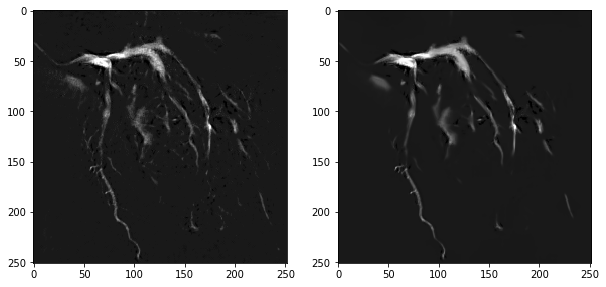

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(im)
plt.subplot(122),plt.imshow(dst)
plt.show()

In [761]:
im = Image.open('gif/Unknown-2.png').convert('RGB')
im = T.ToTensor()(im)
im = (im.permute(1,2,0).numpy()*255).astype('uint8') # tensor2cv2

In [762]:
im = cv2.fastNlMeansDenoisingColored(im,None,10,10,7,21)

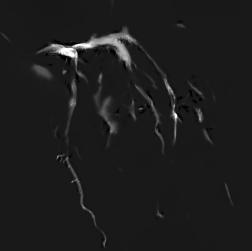

In [763]:
T.ToPILImage()(im)

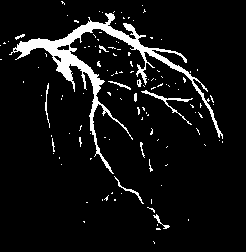

In [922]:
im = cv2.imread('gif/Unknown-3.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
T.ToPILImage()(im)

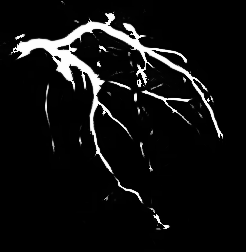

In [923]:
im = cv2.fastNlMeansDenoising(im,None,50,7,21)
# im = (im>50).astype('uint8')*255
T.ToPILImage()(im)

### 多角度融合

(<matplotlib.axes._subplots.AxesSubplot at 0x7f998c7b8450>,
 <matplotlib.image.AxesImage at 0x7f998c778910>)

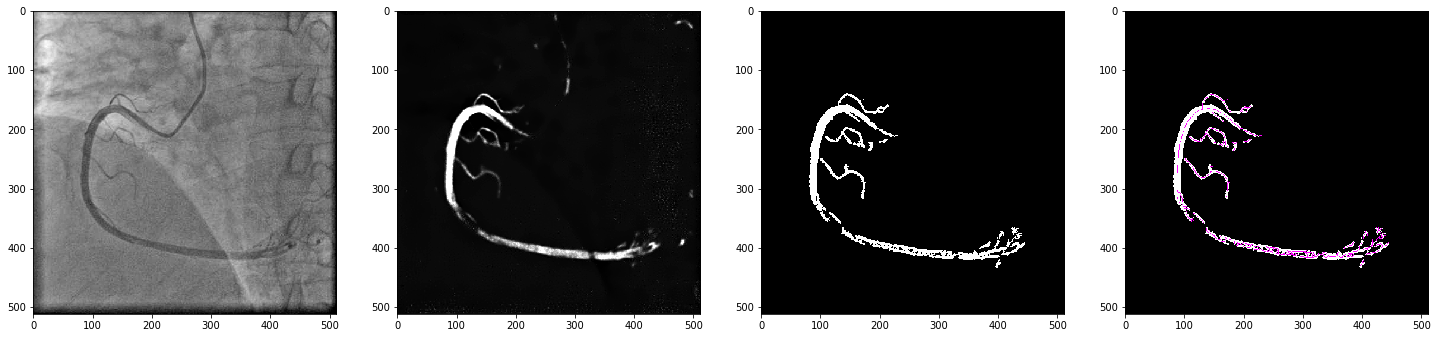

In [55]:
sz = 512
tfmc = T.Compose([
    T.Resize(sz),
    T.Lambda(lambda img: tophat(img,50)),
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

ds = ImageDataset('datasets/cycledsa_v45/', size=sz, unaligned=False, mode='test', transform=tfmc)

netG_B2A = UNet(1, 1, 32, bilinear=True)
netG_B2A = torch.nn.DataParallel(netG_B2A)
ckpts = [
#     'mlruns/0/4a677293b79e4991bd675f50cf70f0b7/049.ckpt', # bs4 baseline ★
#     'mlruns/0/d0ec78cbcebe41d4a91ad5b2edbd4419/049.ckpt', # bs8_b2a2 也不错 可以补偿bs4比如63
#     'mlruns/0/6ea67c47519149c1aa3194fccd1befce/059.ckpt', # bs4_tophat  ★★★★
#     'mlruns/0/125e4597af60496eb73031fd59108ebf/059.ckpt', # bs4_tophat  ★★★ 比上一个血管多些
#     'mlruns/0/b131143473bd49d2b0c30619f8665c79/099.ckpt', # bs4_tophat_ep100
#     'goodckpt/sz512_059.ckpt', # 除10以外，都还可以的★★★，其实细血管识别能力更强 # 504 10 103不好
#         'mlruns/0/8f4634e9eca640beb19eb49e97da10c7/100.ckpt', # ep200 需要探索ep100时★★★★
#      'mlruns/0/ab7b707293c84e529cb191b7d8d5b09e/099.ckpt', # sz512_ep100 杂色多了一点，但血管比sz512好
#      'mlruns/0/457466f4139a4d85a0adac416606e90b/060.ckpt', # sz512_ep100_down3    
#          'mlruns/0/e92b15a61d2c4813aa81d879f22422e7/099.ckpt', # ep100
#     'mlruns/3/c1e2f620956f4622bb0857b43f922a19/last.ckpt', # noRotate20
#     'mlruns/3/df36014de3c04e8d87cc10f3976e66e6/last.ckpt', # Rotate20
#         'mlruns/3/c773a0696e7d43968030776566c6c90a/last.ckpt' # tophat
#     'mlruns/3/84064c391fa746abbcac4bae7982f216/005.ckpt', # hp
#      'mlruns/3/08c7c3e5a3164ed6bd09326ad5845317/033.ckpt', # ep40 33比较好
#          'mlruns/3/b92abac0f439438d9a23fe4c7442caa2/last.ckpt' # rot_ep40 比较好
#      'mlruns/3/4f9ec98f7f5c439e9100c7cb82e8affc/last.ckpt', # hp_ep40 比较好
     'mlruns/3/717b1625375147ba9e7f68bf47be9296/059.ckpt', # sz512
]

# # resnet
# netG_B2A = Generator(1, 1)
# netG_B2A = torch.nn.DataParallel(netG_B2A)
# ckpts = [
#     'mlruns/0/bed13f38d5e148baac9563841815eabf/048.ckpt', # bs4_res 其他挺，但103不好
#     'mlruns/0/1d40d2833f82492c90aecdb4343bdb1a/048.ckpt', # bs4_res_noRoate sota3
#     'mlruns/0/78e1e67ae33b4c8aa95ba095f11f939f/038.ckpt', # bs4_res_tophat_noRotate
#     'mlruns/0/c03f607a02424ac98a9a612bcdfb83e4/049.ckpt', # bs4_res_tophat ★★★ 背景识别更精准
#      'mlruns/3/cc806258307844ecaa4c430acb757616/018.ckpt', # res_sz512_ep20
# ]

idx = 51
ids =[13,14,33,9,10,99,108,45] # 63 88 103 200有病变 300-302 413高度混杂 414狭窄 502低对比度 504残缺 131低对比度 100大伪影
# good 65 66 68 44 34
x = ds[idx]['B']
B,out = fusion_predict(netG_B2A, ckpts, x, multiangle=False, denoise=3, size=sz, cutoff=1, pad=0, padding_mode='constant')
# B,out = fusion_predict(netG_B2A, ckpts, x, multiangle=False, denoise=3, size=sz, cutoff=1, pad=0, padding_mode='reflect')

mask, skel = make_mask(out,remove_size=1000, return_skel=True,local_kernel=15)

out = T.functional.adjust_gamma(out,1.5)

plt.figure(figsize=(25,25))
plt.subplot(141),plt.imshow(B)
plt.subplot(142),plt.imshow(out)
plt.subplot(143),plt.imshow(mask,cmap='gray')
plt.subplot(144),plt.imshow(skel)

# plt.show()

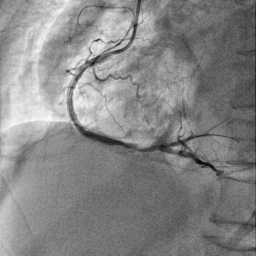

In [41]:
T.ToPILImage()(denorm(x))

In [32]:
B_hat = netG_B2A(x.unsqueeze(0))

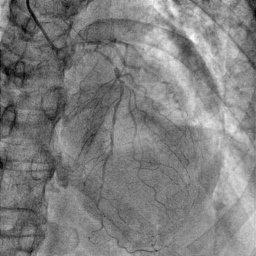

In [35]:
T.ToPILImage()(denorm(B_hat).squeeze(0))

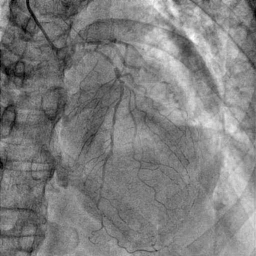

In [36]:
B_hat2 = netG_B2A(B_hat)
T.ToPILImage()(denorm(B_hat2).squeeze(0))

### CKPT Merge

In [59]:
ckpts = []
ckpts.append(torch.load('mlruns/0/e92b15a61d2c4813aa81d879f22422e7/099.ckpt', map_location='cpu')['netG_B2A'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/140.ckpt', map_location='cpu')['netE'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/160.ckpt', map_location='cpu')['netE'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/199.ckpt', map_location='cpu')['netE'])


ckptm = merge_ckpts(ckpts)

x = ds[idx]['B']
B,out = fusion_predict(netG_B2A, [ckptm], x, pad=50, multiangle=True, denoise=5, size=sz)
mask, skel = make_mask(out,remove_size=1000, return_skel=True)
out = T.functional.adjust_gamma(out,1.5)



plt.figure(figsize=(25,25))
plt.subplot(141),plt.imshow(B)
plt.subplot(142),plt.imshow(out)
plt.subplot(143),plt.imshow(mask,cmap='gray')
plt.subplot(144),plt.imshow(skel)

plt.show()

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "model.1.weight", "model.1.bias", "model.4.weight", "model.4.bias", "model.7.weight", "model.7.bias", "model.10.conv_block.1.weight", "model.10.conv_block.1.bias", "model.10.conv_block.5.weight", "model.10.conv_block.5.bias", "model.11.conv_block.1.weight", "model.11.conv_block.1.bias", "model.11.conv_block.5.weight", "model.11.conv_block.5.bias", "model.12.conv_block.1.weight", "model.12.conv_block.1.bias", "model.12.conv_block.5.weight", "model.12.conv_block.5.bias", "model.13.conv_block.1.weight", "model.13.conv_block.1.bias", "model.13.conv_block.5.weight", "model.13.conv_block.5.bias", "model.14.conv_block.1.weight", "model.14.conv_block.1.bias", "model.14.conv_block.5.weight", "model.14.conv_block.5.bias", "model.15.conv_block.1.weight", "model.15.conv_block.1.bias", "model.15.conv_block.5.weight", "model.15.conv_block.5.bias", "model.16.conv_block.1.weight", "model.16.conv_block.1.bias", "model.16.conv_block.5.weight", "model.16.conv_block.5.bias", "model.17.conv_block.1.weight", "model.17.conv_block.1.bias", "model.17.conv_block.5.weight", "model.17.conv_block.5.bias", "model.18.conv_block.1.weight", "model.18.conv_block.1.bias", "model.18.conv_block.5.weight", "model.18.conv_block.5.bias", "model.19.weight", "model.19.bias", "model.22.weight", "model.22.bias", "model.26.weight", "model.26.bias". 
	Unexpected key(s) in state_dict: "inc.double_conv.0.weight", "inc.double_conv.0.bias", "inc.double_conv.3.weight", "inc.double_conv.3.bias", "down1.maxpool_conv.1.double_conv.0.weight", "down1.maxpool_conv.1.double_conv.0.bias", "down1.maxpool_conv.1.double_conv.3.weight", "down1.maxpool_conv.1.double_conv.3.bias", "down2.maxpool_conv.1.double_conv.0.weight", "down2.maxpool_conv.1.double_conv.0.bias", "down2.maxpool_conv.1.double_conv.3.weight", "down2.maxpool_conv.1.double_conv.3.bias", "down3.maxpool_conv.1.double_conv.0.weight", "down3.maxpool_conv.1.double_conv.0.bias", "down3.maxpool_conv.1.double_conv.3.weight", "down3.maxpool_conv.1.double_conv.3.bias", "down4.maxpool_conv.1.double_conv.0.weight", "down4.maxpool_conv.1.double_conv.0.bias", "down4.maxpool_conv.1.double_conv.3.weight", "down4.maxpool_conv.1.double_conv.3.bias", "up1.conv.double_conv.0.weight", "up1.conv.double_conv.0.bias", "up1.conv.double_conv.3.weight", "up1.conv.double_conv.3.bias", "up2.conv.double_conv.0.weight", "up2.conv.double_conv.0.bias", "up2.conv.double_conv.3.weight", "up2.conv.double_conv.3.bias", "up3.conv.double_conv.0.weight", "up3.conv.double_conv.0.bias", "up3.conv.double_conv.3.weight", "up3.conv.double_conv.3.bias", "up4.conv.double_conv.0.weight", "up4.conv.double_conv.0.bias", "up4.conv.double_conv.3.weight", "up4.conv.double_conv.3.bias", "outc.conv.weight", "outc.conv.bias". 